# Efecto de la cuarentena
> Evolución los casos en relación a cómo lo hacían previo al aislamiento obligatorio

- comments: false
- author: Pablo Zivic
- categories: [graficos, fit exponencial]
- image: images/fit-exponencial.png
- permalink: /efecto-cuarentena/

In [1]:
#hide
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from io import StringIO
import pandas as pd
import requests
from datetime import datetime, date

sns.set()

In [2]:
# hide
# Get the data from curated Argentinan source
response = requests.get('https://docs.google.com/spreadsheet/ccc?key=1M7uDgWSfy6z1MNbC9FP6jTNgvY7XchJ0m-BfW88SKtQ&output=csv')

assert response.status_code == 200, 'Wrong status code'

df = pd.read_csv(StringIO(response.content.decode('utf8')))
df.columns = df.iloc[16].values
df = df[18:].iloc[:, :5].copy()
df = df[~df.Casos.isna()]
df.Casos = df.Casos.apply(int)
df['date'] = df.Fecha.apply(lambda x: datetime.strptime(x, '%d/%m/%Y').date())

In [3]:
#hide

from sklearn.linear_model import LinearRegression
from datetime import timedelta
import numpy as np
import matplotlib.dates as mdates
import statsmodels.api as sm

def exp_fit(cut_point=date(2020, 3, 20), start_point=None, 
            log_scale=False, fit_intercept=True, field='Casos',
            is_cover=False):
    """
    Fits an exponential curve and plots it
    """
    if start_point is None:
        skip_samples = 0        
        cases = df.set_index('date')[field][:cut_point]
    else:
        skip_samples = df.date.tolist().index(start_point)
        cases = df.set_index('date')[field][start_point: cut_point]

    x = np.arange(len(cases))
    mc = 0 if fit_intercept else np.log(cases.values.min())
    y = np.log(cases.values) - mc
    
    lr = LinearRegression(fit_intercept=fit_intercept)
    lr.fit(x.reshape((-1,1)), y)

    forecast = np.exp(
        lr.predict(
            np.arange(-skip_samples, len(df) - skip_samples).reshape((-1, 1))
        ) + mc
    )
    dates = [e.date() for e in pd.date_range(df.date.min(), df.date.max())]
    forecast = pd.Series(forecast, index=dates)
    
    linewidth = 10 if is_cover else 4
    markersize = 10 if is_cover else 8

    df.set_index('date')[field].plot(style='-o', linewidth=linewidth, markersize=markersize)
    if not is_cover:
        for i, doc in enumerate(df.to_dict(orient='records')):
            if i < len(df) - 1: continue
            text_y = doc[field] * 1.5 if log_scale else doc[field] + 200 
            plt.text(
                doc['date'], text_y , 
                int(doc[field]), fontdict=dict(size=9),
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.5),
                horizontalalignment='center'
            )
    
    forecast.plot(label='Predicción', style='-o', alpha=0.6, linewidth=linewidth, markersize=markersize)
    
    last_date = df.date.max()
    plt.text(
        last_date, 
        forecast.loc[last_date] * 1.5 if log_scale else forecast.loc[last_date] + 200,
        int(forecast.loc[last_date]),
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.5),
        horizontalalignment='center'
    )
    
    plt.vlines(x=last_date, ymin=df.Casos.max(), ymax=forecast.loc[last_date], linestyles='--')
    
    cases.plot(style='-o', label='Casos usados para el modelo', linewidth=linewidth, markersize=markersize) 
        
    ymax = forecast.max() * (3 if log_scale else 1.2)
    
    plt.vlines(cut_point, 1, ymax, linestyle='--')
    plt.fill_between(
        [cut_point, df.date.max() + timedelta(days=skip_samples)], 
        1, ymax, color='k', alpha=0.2
    )
    plt.text(
        cut_point + timedelta(days=2), 
        df[field].max() * (0.05 if log_scale else 1.4), 
        'Cuarentena', 
        fontdict=dict(size=20)
    )

    plt.legend(loc='best')
    if log_scale: plt.yscale('log')
    
    plt.xlim(df.date.min(), df.date.max() + timedelta(days=skip_samples))
    ax = plt.gca()
    # set monthly locator
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
    # set formatter
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
    # set font and rotation for date tick labels
    plt.xticks(rotation=30)
    plt.ylim(-100 + 100.8 * log_scale, ymax)
    
    
    y = df.set_index('date')[field]
    if start_point: y = y[start_point:]
    y = y.values
    return lr, np.abs((np.exp(lr.predict(np.arange(len(y)).reshape((-1, 1))) + mc) - y) / y).mean()


Coeficiente: 1.24, Constante:9.84


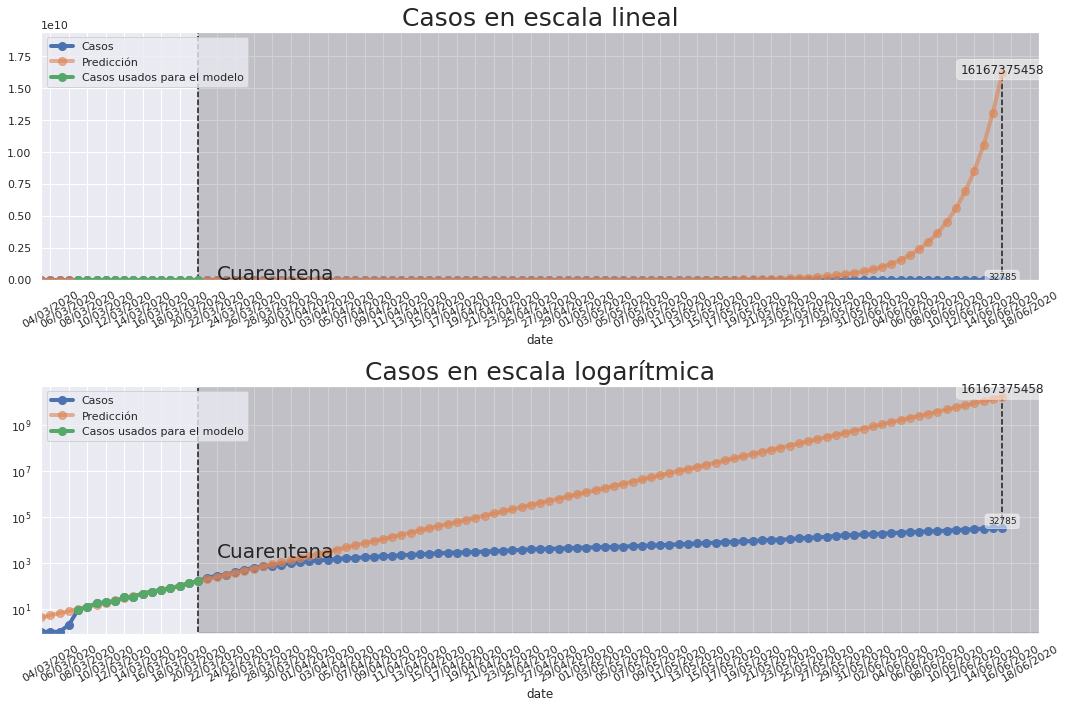

In [4]:
#hide_input

plt.figure(figsize=(15,10))
plt.subplot(211)

plt.title('Casos en escala lineal', fontdict=dict(size=25))
exp_fit(start_point=date(2020, 3, 7), field='Casos')

plt.subplot(212)
plt.title('Casos en escala logarítmica', fontdict=dict(size=25))

lr, mse = exp_fit(start_point=date(2020, 3, 7), log_scale=True, field='Casos')
print(f'Coeficiente: {np.exp(lr.coef_[0]):.02f}, Constante:{np.exp(lr.intercept_):.02f}')
plt.tight_layout();

# Cómo leer el gráfico

En este gráfico podemos ver 2 paneles, ambos muestran lo mismo: la cantidad de casos confirmados a través del tiempo. El panel superior está en escala lineal, el inferior en escala logarítmica

En ambos paneles, hay 3 curvas: la azul, la naranja y la verde. Paso a explicar

* **Azul**: Son los datos correspondientes a cantidad de infectades
* **Verde**: Son los datos utilizados por el modelo. No considera los primeros 4 días porque tienen mucho ruido (se puede ver en la escala logarítmica)
* **Naranja**: La funcion exponencial que mejor se ajusta a los datos _previos a la cuarentena_

Si la cuarentena no tuviera efecto, esperaríamos que los casos confirmados sigan ajustandose a la figura exponencial

Notas:
1. La cuarentena no es el único factor que afecta la cantidad de casos. Existen otros como la cantidad de tests realizados que pueden afectar estos números
2. El período de incubación de la enfermedad, mas el período que toma hacer el estudio hace que todas las curvas se encuentren atrasadas. Es decir, es de esperarse que las curvas no se despeguen los primeros días de la cuarentena.


## Nota personal
Al no ser epidemiólogo, me limito a mostrar la información, pero no considero tener la formación, ni la experiencia para usar esto para evaluar la situación de COVID-19 en la Argentina. Aprovecho para reconocer el **excelente** trabajo que están haciendo las autoridades nacionales, provinciales, de salud, etc para contener la situación y llevarla a buen puerto.

Además quiero agradecer a [Jorge Aliaga](https://twitter.com/jorgeluisaliaga) por tenerme paciencia, juntar los datos en [este spreadsheet](https://docs.google.com/spreadsheets/d/1M7uDgWSfy6z1MNbC9FP6jTNgvY7XchJ0m-BfW88SKtQ/edit#gid=0) y por el rico intercambio que tuvimos por twitter.

Por último, en caso de estar interesade en leer más sobre modelos epidemiológicos, dejo un [link a un excelente post que habla sobre el modelo SIR](https://medium.com/data-for-science/epidemic-modeling-101-or-why-your-covid19-exponential-fits-are-wrong-97aa50c55f8)

In [5]:
#hide

fig = plt.figure()

exp_fit(start_point=date(2020, 3, 7), field='Casos', is_cover=True)
plt.tight_layout()
plt.xticks([])
fig.savefig('../images/fit-exponencial.png')
plt.close()

In [6]:
!open ../images/fit-exponencial.png

Couldn't get a file descriptor referring to the console
